<div style="background-color:#e8f5e9; padding:20px; border-radius:10px; text-align:center;">

# XGBoost - Backtesting  
**by A.B.**

<br>

This notebook explores the use of the XGBoost algorithm for financial market prediction.  
By leveraging historical price and engineered features (like EMA, ATR, and volatility thresholds),  
we train and evaluate an XGBoost classifier to detect potential trading signals.  
The model is then backtested to assess predictive performance and robustness in realistic conditions.

</div>

<br>

Slice rows to save time to conduct experiments.

In [1]:
import pandas as pd
df = pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2021-30.09.2024.csv")
df = df.loc[:50000]

In [2]:
result = (50000 * 5 / 60) / 24
result

173.61111111111111

Around 6 month of data

### Long Positions Volatility Related Labeling
Detecting potential long trades.Calculating dynamic upper and lower thresholds around the current price. 
* price exceeding upper threshold -> uptrend
* price exceeding lower threshold -> downtrend

In [3]:
import pandas_ta as ta
def atr_label_threshold_long(df, bars):
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'])

    ratio = 1
    slcoef = 1
    tpcoef = ratio*slcoef

    lower_threshold_long = df['Close'] - df['ATR']*slcoef
    upper_threshold_long = df['Close'] + df['ATR']*tpcoef

    df = df.reset_index(drop=True)

    df['Label_Long'] = 0
    for i in range(len(df) - bars):   
       
        # Check if any future Close prices are above the upper threshold at the current index
        condition_1 = (df['Close'][i + 1:i + bars + 1] > upper_threshold_long.iloc[i]).any()
        # Ensure none of the future Close prices are below the lower threshold at the current index
        condition_2 = (df['Close'][i + 1:i + bars + 1] > lower_threshold_long.iloc[i]).all()

        # Set label based on conditions
        if condition_1 and condition_2:
            df.loc[i, 'Label_Long'] = 1

    return df

In [4]:
df = atr_label_threshold_long(df, 10)

This small offset ensures signal markers don’t overlap the candlestick visuals when plotting.

In [5]:
import numpy as np
def pointpos(x, col):
    if x[col]==1:
        return x['Low']-1e-3
    elif x[col]==-1:
        return x['High']+1e-3
    else:
        return np.nan

### Short Positions Volatility Related Labeling

Detecting potential short trades.  
- The future closing price drops  below a lower threshold    at least once and
- The price  never exceeds an upper threshold  during the lookahead period.

In [6]:
def atr_label_threshold_short(df, bars):
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'])

    ratio = 1 # ratio for the stop loss and take profit
    slcoef = 1
    tpcoef = ratio*slcoef

    lower_threshold_short = df['Close'] - df['ATR']*tpcoef
    upper_threshold_short = df['Close'] + df['ATR']*slcoef

    df = df.reset_index(drop=True)

    # conditions for a short position where we're 
    # looking for the price to drop below a lower 
    # threshold without crossing an upper threshold in the future.

    df['Label_Short'] = 0
    for i in range(len(df) - bars):
        
        # Check if any future Close prices are below the lower threshold at the current index
        condition_1 = (df['Close'][i + 1:i + bars + 1] < lower_threshold_short.iloc[i]).any()
        
        # Ensure none of the future Close prices are above the upper threshold at the current index
        condition_2 = (df['Close'][i + 1:i + bars + 1] < upper_threshold_short.iloc[i]).all()
        
        # Set label based on conditions
        if condition_1 and condition_2:
            df.loc[i, 'Label_Short'] = -1

    return df

In [7]:
df = atr_label_threshold_short(df, 10)

In [8]:
df["Label"] = df["Label_Long"] + df["Label_Short"]
df[df["Label"]!=0]

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,Label_Short,Label
16,30.09.2021 01:20:00.000,1.16044,1.16044,1.16015,1.16032,134.420000,0.000179,1,0,1
17,30.09.2021 01:25:00.000,1.16031,1.16035,1.16021,1.16027,109.230000,0.000175,1,0,1
18,30.09.2021 01:30:00.000,1.16028,1.16034,1.16014,1.16031,141.430000,0.000178,1,0,1
19,30.09.2021 01:35:00.000,1.16030,1.16053,1.16026,1.16052,202.500000,0.000186,1,0,1
20,30.09.2021 01:40:00.000,1.16053,1.16061,1.16040,1.16045,123.360000,0.000189,1,0,1
...,...,...,...,...,...,...,...,...,...,...
49985,27.05.2022 20:30:00.000,1.07308,1.07320,1.07306,1.07311,0.000117,0.000358,1,0,1
49986,27.05.2022 20:35:00.000,1.07312,1.07312,1.07307,1.07309,0.000107,0.000336,1,0,1
49987,27.05.2022 20:40:00.000,1.07306,1.07315,1.07304,1.07309,0.000121,0.000320,1,0,1
49988,27.05.2022 20:45:00.000,1.07309,1.07340,1.07308,1.07314,0.000273,0.000320,1,0,1


In [9]:
df['pointpos'] = df.apply(lambda row: pointpos(row,"Label"), axis=1)

Qickly assess the quality and positioning of labeled signals in the context of price action.

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")

fig.show()

### Adding EMA and EMA Slope as features

In [11]:
df["ema30"] = ta.ema(df['Close'], length=30)
df

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,Label_Short,Label,pointpos,ema30
0,30.09.2021 00:00:00.000,1.16018,1.16019,1.15980,1.15997,319.83,NaN,0,0,0,NaN,NaN
1,30.09.2021 00:05:00.000,1.15996,1.16002,1.15982,1.15992,124.99,NaN,0,0,0,NaN,NaN
2,30.09.2021 00:10:00.000,1.15991,1.16006,1.15979,1.16002,155.57,NaN,0,0,0,NaN,NaN
3,30.09.2021 00:15:00.000,1.16002,1.16013,1.15998,1.16012,214.94,NaN,0,0,0,NaN,NaN
4,30.09.2021 00:20:00.000,1.16011,1.16021,1.16011,1.16021,123.87,NaN,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49996,28.05.2022 00:25:00.000,1.07393,1.07393,1.07393,1.07393,0.00,0.000223,0,0,0,NaN,1.073135
49997,28.05.2022 00:30:00.000,1.07393,1.07393,1.07393,1.07393,0.00,0.000207,0,0,0,NaN,1.073186
49998,28.05.2022 00:35:00.000,1.07393,1.07393,1.07393,1.07393,0.00,0.000192,0,0,0,NaN,1.073234
49999,28.05.2022 00:40:00.000,1.07393,1.07393,1.07393,1.07393,0.00,0.000179,0,0,0,NaN,1.073279


In [12]:
from scipy.stats import linregress

def compute_slope(window):
    # Use only the last 5 values of the window
    if len(window) < 5:
        return np.nan  # Not enough data to compute the slope
    y = window[-5:]
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

# Apply the function to compute the slope of ema20
df['ema30_Slope'] = df['ema30'].rolling(window=5, min_periods=5).apply(compute_slope, raw=True)

### Adding more Moving Averages

 - Returns 1 if the shorter-term EMA is above both longer-term EMAs -bullish
  - Returns  -1  if the shorter-term EMA is below both - bearish 
  - Returns 0  otherwise  uncertain or transitioning trend .

In [13]:
df['ema50'] = ta.ema(df['Close'], length=50)
df['ema100'] = ta.ema(df['Close'], length=100)

In [14]:
def ema_positions(row):
    if row['ema30'] > row['ema50'] > row['ema100']:
        return 1
    elif row['ema30'] < row['ema50'] < row['ema100']:
        return -1
    else:
        return 0

In [15]:
# Apply the function to create the 'ema_Positions' column for later use
df['ema_Positions'] = df.apply(ema_positions, axis=1)

### Moving Average Distance

 can be used to detect pullback opportunities or overextensions

In [16]:
def compute_distance(row):
    # Determine the closest point to EMA20 (either Open or Close)
    closest_point = min(row['Open'], row['Close'], key=lambda x: abs(x - row['ema30']))
    # Compute the absolute distance between the closest point and EMA20
    distance = row['ema30'] - closest_point
    return distance

In [17]:
df['Distance_to_ema30'] = df.apply(compute_distance, axis=1)

### Putting all indicators in place

In [18]:
df['RSI']=ta.rsi(df.Close, length=10)
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df=df.join(my_bbands)

In [19]:
def ema_signal(df, current_candle, backcandles):
    df_slice = df.reset_index().copy()
    # Get the range of candles to consider
    start = max(0, current_candle - backcandles)
    end = current_candle
    relevant_rows = df_slice.iloc[start:end]

    # Check if all EMA_fast values are below EMA_slow values
    if all(relevant_rows["ema30"] < relevant_rows["ema50"]):
        return 1
    elif all(relevant_rows["ema30"] > relevant_rows["ema50"]):
        return 2
    else:
        return 0

def BB_signal(df, current_candle, backcandles):
    candle_open_price = df.Open[current_candle]
    bbl = df['BBL_15_1.5'][current_candle]
    bbu = df['BBU_15_1.5'][current_candle]

    if (candle_open_price<=bbl): #and df.RSI[current_candle]>45
            return 2
    if (candle_open_price>=bbu): #and df.RSI[current_candle]<65
            return 1
    return 0

def total_signal(df, current_candle, backcandles):
    ema_signal_result = ema_signal(df, current_candle, backcandles)
    candle_open_price = df.Open[current_candle]
    bbl = df['BBL_15_1.5'][current_candle]
    bbu = df['BBU_15_1.5'][current_candle]

    if (ema_signal_result==2 and candle_open_price<=bbl): #and df.RSI[current_candle]<60
            return 2
    if (ema_signal_result==1 and candle_open_price>=bbu): #and df.RSI[current_candle]>40
            return 1
    return 0

In [20]:
# Apply the EMA signal function and save the result in a new column
df['ema_signal'] = [ema_signal(df, i, backcandles=7) for i in range(len(df))]

# Apply the BB signal function and save the result in a new column
df['BB_signal'] = [BB_signal(df, i, backcandles=7) for i in range(len(df))]

# Apply the total signal function and save the result in a new column
df['total_signal'] = [total_signal(df, i, backcandles=7) for i in range(len(df))]

### Data Preprocessing, No Data Leakage

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Drop NA values
analyze_col = ["Volume", "ATR", "ema30_Slope", "Distance_to_ema30", 'ema_Positions', "RSI", "ema_signal", "BB_signal", "total_signal", "Label_Long"]
df_analysis = df.dropna().copy().loc[:,analyze_col]
df_backtest = df.dropna().copy()

# Define features and label
X = df_analysis.drop(['Label_Long'], axis=1)
y = df_analysis['Label_Long']

# Split the dataset into training and testing sets sequentially
split_ratio = 0.9
split_point = int(len(df_analysis) * split_ratio)
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

# One-Hot Encoding
columns_to_encode = ["ema_Positions", 'ema_signal', 'BB_signal', 'total_signal']
# Generate one-hot encoded variables for both training and testing datasets directly
X_train_encoded = pd.get_dummies(X_train[columns_to_encode], columns=columns_to_encode, prefix=columns_to_encode)
X_test_encoded = pd.get_dummies(X_test[columns_to_encode], columns=columns_to_encode, prefix=columns_to_encode)

# Align the columns of the encoded DataFrames to ensure they have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='outer', axis=1, fill_value=0)

X_train_poly = X_train.drop(columns=columns_to_encode)
X_test_poly = X_test.drop(columns=columns_to_encode)
feature_names = X_train.drop(columns=columns_to_encode).columns

# Standardization
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Convert to DataFrame
X_train_poly_df = pd.DataFrame(X_train_poly_scaled, columns=feature_names, index=X_train.index)
X_test_poly_df = pd.DataFrame(X_test_poly_scaled, columns=feature_names, index=X_test.index)

# Join the polynomial features with the encoded features
X_train_final = X_train_poly_df.join(X_train_encoded)
X_test_final = X_test_poly_df.join(X_test_encoded)

X_train_pca_df = X_train_final
X_test_pca_df = X_test_final


### Final data and signals compiled together

In [22]:
X_train_pca_df

,Volume,ATR,ema30_Slope,Distance_to_ema30,RSI,ema_Positions_-1,ema_Positions_0,ema_Positions_1,ema_signal_0,ema_signal_1,ema_signal_2,BB_signal_0,BB_signal_1,BB_signal_2,total_signal_0,total_signal_1,total_signal_2
99,0.478765,0.013143,0.466857,-0.241281,0.207733,False,True,False,True,False,False,True,False,False,True,False,False
100,0.589459,-0.000800,0.353620,-0.236852,0.318554,False,True,False,True,False,False,True,False,False,True,False,False
101,0.905217,-0.000466,0.272593,-0.176899,0.120109,False,True,False,True,False,False,True,False,False,True,False,False
102,0.352846,-0.039992,0.250934,-0.153886,0.477507,False,True,False,True,False,False,True,False,False,True,False,False
103,0.331684,-0.010301,0.209016,0.032591,-0.213596,False,True,False,False,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45156,0.896466,-0.329540,-0.016860,0.055282,-0.808656,False,True,False,False,True,False,True,False,False,True,False,False
45157,0.948819,-0.372084,-0.210419,0.441582,-0.856675,False,True,False,False,True,False,False,False,True,True,False,False
45158,0.408960,-0.345230,-0.300535,0.194012,-0.313781,False,True,False,False,True,False,False,False,True,True,False,False
45159,-0.124527,-0.393289,-0.277638,0.094291,-0.145250,False,True,False,False,True,False,True,False,False,True,False,False


# Here Training  Machine Learning Models

### XGBoost Classifier with Feature Importance

This section implements an **XGBoost Classifier** to evaluate predictive power on the PCA-transformed feature set.

- Uses `'logloss'` as the evaluation metric, suitable for binary classification.
- Predicts class probabilities on the test set and applies a threshold (set to `0.8` here) for binary classification.
- The `predict_proba` output allows finer control over decision boundaries by tuning the threshold.

It also visualizes **feature importance** (based on split frequency or "weight"), helping identify the most influential features driving the model's decisions.


In [23]:
import xgboost as xgb

clf = xgb.XGBClassifier(eval_metric='logloss', random_state=30)
clf.fit(X_train_pca_df, y_train)
# Predicting the test set results
#y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test_pca_df)[:, 1]  # Get probabilities for the positive class

threshold = 0.8  # Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)

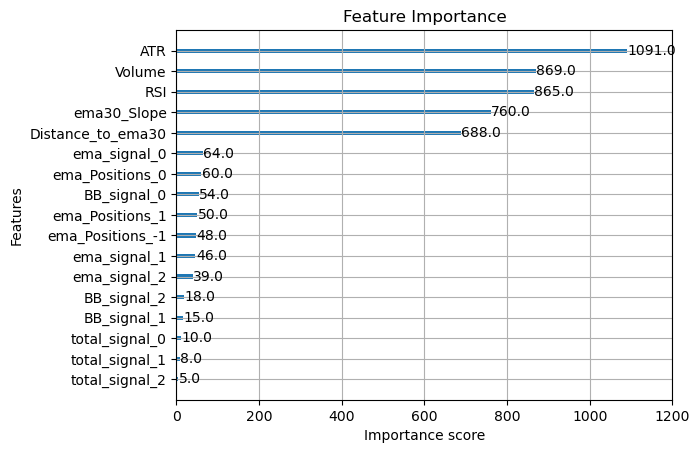

In [24]:
# Plot feature importance
xgb.plot_importance(clf, importance_type='weight')
plt.title('Feature Importance')
plt.show()

Accuracy Score: 0.5026075619295959
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.97      0.66      1550
           1       0.45      0.02      0.04      1518

    accuracy                           0.50      3068
   macro avg       0.48      0.50      0.35      3068
weighted avg       0.48      0.50      0.36      3068



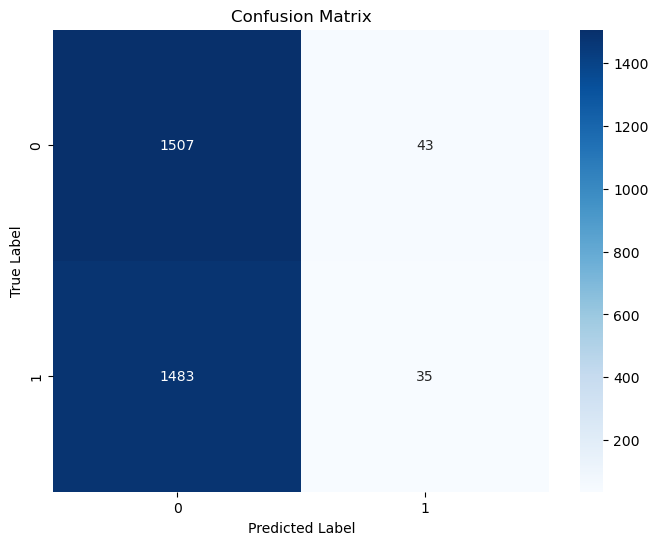

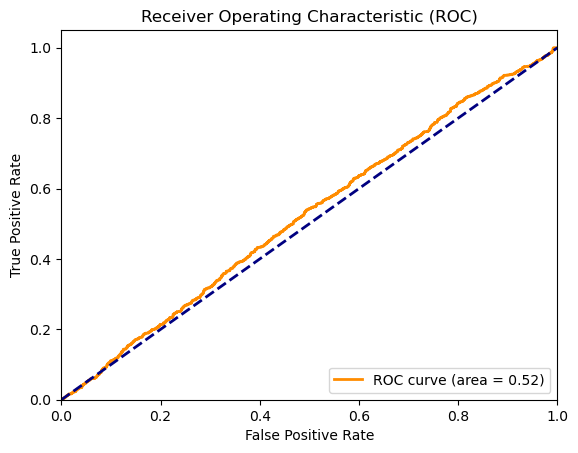

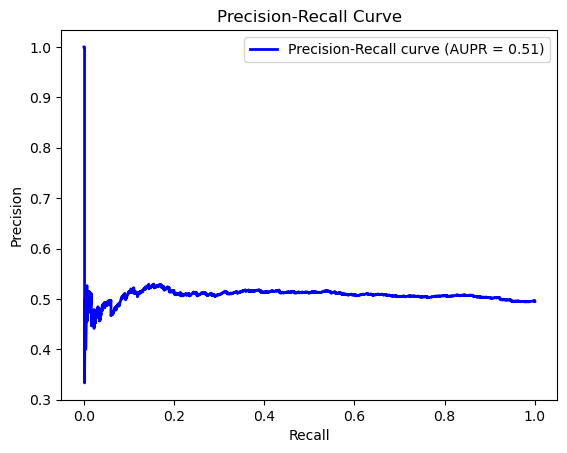

In [25]:
# Evaluating the classifier
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
aupr = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUPR = %0.2f)' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


In [26]:
df_backtest = df_backtest.iloc[split_point:]
df_backtest["Pred_Signal"] = y_pred #  machine learning signal
df_backtest


,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,Label_Short,Label,...,RSI,BBL_15_1.5,BBM_15_1.5,BBU_15_1.5,BBB_15_1.5,BBP_15_1.5,ema_signal,BB_signal,total_signal,Pred_Signal
45161,04.05.2022 01:30:00.000,1.05261,1.05287,1.05258,1.05263,791.630000,0.000310,1,0,1,...,57.525709,1.052047,1.052363,1.052679,0.060064,0.922936,1,0,0,0
45162,04.05.2022 01:35:00.000,1.05264,1.05269,1.05248,1.05249,460.900000,0.000303,1,0,1,...,52.514987,1.052073,1.052383,1.052694,0.058990,0.671820,1,0,0,0
45163,04.05.2022 01:40:00.000,1.05251,1.05311,1.05249,1.05307,522.620000,0.000326,0,-1,-1,...,66.105258,1.052059,1.052445,1.052832,0.073488,1.307664,1,0,0,0
45164,04.05.2022 01:45:00.000,1.05308,1.05335,1.05294,1.05320,898.490000,0.000332,0,-1,-1,...,68.360408,1.052016,1.052495,1.052974,0.091027,1.236216,1,1,1,0
45165,04.05.2022 01:50:00.000,1.05316,1.05317,1.05286,1.05296,777.410000,0.000332,0,-1,-1,...,60.151010,1.052016,1.052526,1.053036,0.096842,0.925790,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49985,27.05.2022 20:30:00.000,1.07308,1.07320,1.07306,1.07311,0.000117,0.000358,1,0,1,...,63.358730,1.072286,1.072807,1.073328,0.097131,0.790460,0,0,0,0
49986,27.05.2022 20:35:00.000,1.07312,1.07312,1.07307,1.07309,0.000107,0.000336,1,0,1,...,62.592421,1.072387,1.072864,1.073341,0.089000,0.736687,0,0,0,0
49987,27.05.2022 20:40:00.000,1.07306,1.07315,1.07304,1.07309,0.000121,0.000320,1,0,1,...,62.592421,1.072535,1.072926,1.073317,0.072819,0.709909,0,0,0,0
49988,27.05.2022 20:45:00.000,1.07309,1.07340,1.07308,1.07314,0.000273,0.000320,1,0,1,...,63.938576,1.072653,1.072978,1.073303,0.060496,0.749572,0,0,0,0


In [27]:
def SIGNAL():
    return df_backtest.Pred_Signal

In [28]:
from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    mysize = 0.99 # trading woith around all the equity
    slcoef = 1
    TPSLRatio = 1.4 # we can set this to 1.4 or 2.0 for more risk
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1] #stop loss atr distance
        TPSLRatio = self.TPSLRatio
        
        if self.signal1==1:
            sl1 = self.data.Close[-1] - slatr #current close - atr distance
            tp1 = self.data.Close[-1] + slatr*TPSLRatio #current close + atr distance * ratio
            self.buy(sl=sl1, tp=tp1, size=self.mysize) # buy signal only long positions fornow
        
bt = Backtest(df_backtest, MyStrat, cash=250, margin=1/30, commission=0.0) # no commission for now

bt.run()

c:\Users\learn\anaconda3\Lib\site-packages\backtesting\_plotting.py:55: UserWarning:

Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.



Loading BokehJS ...

c:\Users\learn\anaconda3\Lib\site-packages\backtesting\backtesting.py:1200: FutureWarning:

Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead

C:\Users\learn\AppData\Local\Temp\ipykernel_5192\4103140302.py:23: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/3067 [00:00<?, ?bar/s]

c:\Users\learn\anaconda3\Lib\site-packages\backtesting\backtesting.py:954: UserWarning:

time=239: Broker canceled the relative-sized order due to insufficient margin.

c:\Users\learn\anaconda3\Lib\site-packages\backtesting\backtesting.py:954: UserWarning:

time=245: Broker canceled the relative-sized order due to insufficient margin.

c:\Users\learn\anaconda3\Lib\site-packages\backtesting\backtesting.py:954: UserWarning:

time=247: Broker canceled the relative-sized order due to insufficient margin.

c:\Users\learn\anaconda3\Lib\site-packages\backtesting\backtesting.py:954: UserWarning:

time=419: Broker canceled the relative-sized order due to insufficient margin.

c:\Users\learn\anaconda3\Lib\site-packages\backtesting\backtesting.py:954: UserWarning:

time=420: Broker canceled the relative-sized order due to insufficient margin.

c:\Users\learn\anaconda3\Lib\site-packages\backtesting\backtesting.py:954: UserWarning:

time=1259: Broker canceled the relative-sized order due to insuffi

Start                                 45161.0
End                                   49989.0
Duration                               4828.0
Exposure Time [%]                     6.42112
Equity Final [$]                    273.60853
Equity Peak [$]                     328.02713
Return [%]                            9.44341
Buy & Hold Return [%]                 1.95415
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                             5.56939
Beta                                  1.98246
Max. Drawdown [%]                   -16.75429
Avg. Drawdown [%]                    -3.49848
Max. Drawdown Duration                 3286.0
Avg. Drawdown Duration              512.66667
# Trades                                 71.0
Win Rate [%]                         36.61972
Best Trade [%]                    

In [29]:
bt.plot()

GridPlot(id='p1353', ...)

<div style="text-align: center; border: 2px solid black; padding: 10px; background-color: green; color: white;">
    <h3><i>🏁You have reached the end of this notebook. Thank you!</i></h3>
</div>
